# Advanced pipelines

We again have a pipeline with *preprocessing* and *classification* steps. This time, the grid search will investigate:
- Different classifiers with different hyper-parameters
- For each classifier, different *preprocessing* steps


Follow _Introduction to Machine Learning_ [Chapter 6](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb): 6.6 Grid-Searching Which Model To Use (p.325)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import mglearn

## 2. Grid-Searching Which Model To Use (Heart Disease Dataset)

We will:
- compare encoded preprocessing to un-encoded preprocessing
- compare logistic regression and random forest classifiers

In [3]:
def load_heart_disease():
    '''Load and pre-process heart disease data
    
    if processed.hungarian.data file is not present.
    
    it will be downloaded from
    https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data
    
    categorical variables will be dtype='categorical'
    
    return: data(DataFrame)
    
    '''
    
    import os
    import requests
    
    
    file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data'
    file_name = file_url.split('/')[-1]
    
    if not os.path.isfile(file_name):
        print('Downloading from {}'.format(file_url))
        r = requests.get(file_url)
        with open(file_name,'wb') as output_file:
            output_file.write(r.content)
        
    data = pd.read_csv(file_name, 
                   na_values='?', 
                   names=[ 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs',
                            'restecg', 'thalach', 'exang', 'oldpeak', 'slope',
                            'ca', 'thal', 'num'])
    # change dtype for categorical variables
    data = data.astype({col: 'category' for col in [ 'sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']})
    
    return data

In [4]:
data = load_heart_disease()

In [5]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130.0,132.0,0.0,2.0,185.0,0.0,0.0,NaN,NaN,NaN,0
1,29,1,2,120.0,243.0,0.0,0.0,160.0,0.0,0.0,NaN,NaN,NaN,0
2,29,1,2,140.0,NaN,0.0,0.0,170.0,0.0,0.0,NaN,NaN,NaN,0
3,30,0,1,170.0,237.0,0.0,1.0,170.0,0.0,0.0,NaN,NaN,6.0,0
4,31,0,2,100.0,219.0,0.0,1.0,150.0,0.0,0.0,NaN,NaN,NaN,0


### 2.1 Encoded preprocessor using imputing
preprocessor is a ColumnTransformer with:
- numerical pipline containing SimpleImputer(median) and StandardScaler
- categorical pipeline containing SimpleImputer(most_frequent) and OneHotEncoder

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer,  make_column_selector(dtype_exclude="category")),
        ('cat', categorical_transformer,  make_column_selector(dtype_include="category"))])

In [7]:
from sklearn import set_config
set_config(display='diagram')
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x106277e80>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x157e659a0>)])

### 2.2 Un-encoded preprocessing - using imputing only
imputer is a ColumnTransformer with:
- numerical SimpleImputer(median)
- categorical SimpleImputer(most_frequent) 

In [8]:
imputer = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'),  make_column_selector(dtype_exclude="category")),
        ('cat', SimpleImputer(strategy='most_frequent'),  make_column_selector(dtype_include="category"))])

In [9]:
imputer

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='median'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16a420970>),
                                ('cat', SimpleImputer(strategy='most_frequent'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16a491850>)])

### 2.3 Setting up the pipeline object
Notes:
- Pipeline has two steps: preprocessing and classifier
- use preprocessor and LogisticRegression as placeholders

In [10]:
from sklearn.linear_model import LogisticRegression

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000))])

### 2.4 Setting up the grid search parameter grid
Setup a parameter grid and grid search object:
- Use a list of dict
- Comparing preprocessor and imputer in preprocessing step
- Classifiers e.g. LogisticRegression and RandomForest
- grid search with `cv=5` and `return_train_score=True`

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'classifier': [LogisticRegression(max_iter=5000)], 
     'preprocessor': [preprocessor, imputer],
     'classifier__C': [0.1, 1.0, 10.0, 100.0],
     'classifier__fit_intercept': [True, False]},
    {'classifier': [RandomForestClassifier(random_state=58)],
     'preprocessor': [preprocessor, imputer], 
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [1, 3, 5],
        'classifier__max_features': [7, 9, 11]}]

grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)

### 2.5 Splitting data
Notes:
- use `test_size=0.1, stratify=y,random_state=31`

In [12]:
from sklearn.model_selection import train_test_split

# get all columns apart from income for the features
X = data.drop(columns='num')
y = data['num']
print(X.shape)
print(y.shape)

# split dataframe and income
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.1, stratify=y,random_state=31)

(294, 13)
(294,)


### 2.6 Performing grid search
Notes:
- print best parameters
- print cv training and testing scores
- print test-set score

In [13]:
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation train score: {:.2f}".format(grid.cv_results_['mean_train_score'][grid.best_index_]))
print("Best cross-validation test score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': LogisticRegression(C=10.0, fit_intercept=False, max_iter=5000), 'classifier__C': 10.0, 'classifier__fit_intercept': False, 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x106277e80>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1

## 3. Save the model to file for later use

In [14]:
from joblib import dump, load
dump(grid.best_estimator_, 'heart-disease-classifier.joblib')

['heart-disease-classifier.joblib']

In [15]:
clf = load('heart-disease-classifier.joblib') 
print("Test-set score: {:.2f}".format(clf.score(X_test, y_test)))

Test-set score: 0.90


In [16]:
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16a806e20>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16a806490>)])),
                ('classifier',
                 LogisticRegression(C=10.0, fit_intercept=False,
                                    max_iter=5000))])

## 4. Another option

What if we impute with an out-of-range value?

When we choose an out-of-range value for imputation, the model has a chance to learn from these missing values. Maybe there is a reason values are missing that relates to the prediction.

We might want to use a one-hot-encoder/StandardScaler and LogisticRegression and compare to no encoder/no scaler and RandomForest

In [17]:
imputer_oor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='constant', fill_value=-1),  make_column_selector(dtype_exclude="category")),
        ('cat', SimpleImputer(strategy='constant', fill_value=-1),  make_column_selector(dtype_include="category"))])

In [18]:
numeric_transformer_oor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('scaler', StandardScaler())])

categorical_transformer_oor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_oor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_oor,  make_column_selector(dtype_exclude="category")),
        ('cat', categorical_transformer_oor,  make_column_selector(dtype_include="category"))])

In [19]:
param_grid = [
    {'classifier': [LogisticRegression(max_iter=5000)], 
     'preprocessor': [preprocessor_oor],
     'classifier__C': [0.1, 1.0, 10.0, 100.0],
     'classifier__fit_intercept': [True, False]},
    {'classifier': [RandomForestClassifier(random_state=58)],
     'preprocessor': [imputer_oor], 
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [1, 3, 5],
        'classifier__max_features': [7, 9, 11]}]

grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)

In [20]:
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation train score: {:.2f}".format(grid.cv_results_['mean_train_score'][grid.best_index_]))
print("Best cross-validation validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': LogisticRegression(max_iter=5000), 'classifier__C': 1.0, 'classifier__fit_intercept': True, 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=-1,
                                                                strategy='constant')),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16a7db940>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=-1,
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_un

In [21]:
numeric_features = [col for col in X_train.columns if X_train[col].dtype != "category"]
categorical_features = [col for col in X_train.columns if X_train[col].dtype == "category"]
processed_feature_names = numeric_features +\
                        grid.best_estimator_['preprocessor'].transformers_[1][1]['onehot']\
                           .get_feature_names_out(categorical_features).tolist()
processed_feature_names

['age',
 'trestbps',
 'chol',
 'thalach',
 'oldpeak',
 'sex_0.0',
 'sex_1.0',
 'cp_1.0',
 'cp_2.0',
 'cp_3.0',
 'cp_4.0',
 'fbs_-1.0',
 'fbs_0.0',
 'fbs_1.0',
 'restecg_0.0',
 'restecg_1.0',
 'restecg_2.0',
 'exang_-1.0',
 'exang_0.0',
 'exang_1.0',
 'slope_-1.0',
 'slope_1.0',
 'slope_2.0',
 'slope_3.0',
 'ca_-1.0',
 'ca_0.0',
 'thal_-1.0',
 'thal_3.0',
 'thal_6.0',
 'thal_7.0']

Text(0, 0.5, 'Coefficient magnitude')

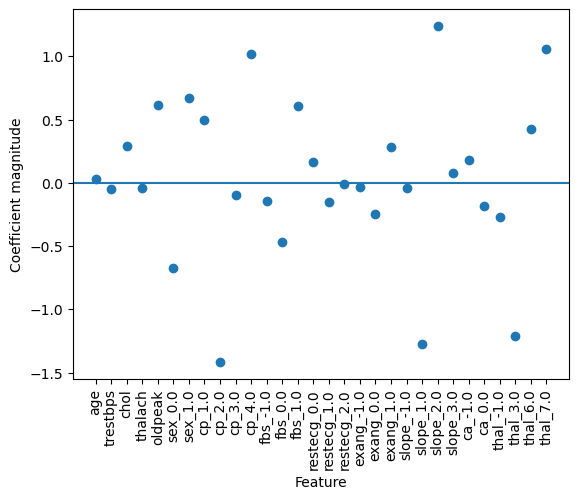

In [22]:
#TODO: Plot the coefficients
plt.plot(grid.best_estimator_['classifier'].coef_.T, 'o')

plt.xticks(range(len(processed_feature_names)), processed_feature_names, rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
# plt.ylim(-5, 5)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
# plt.legend()

In [23]:
idxs = [idx for idx, col in enumerate(processed_feature_names) if "-1.0" in col]

In [24]:
grid.best_estimator_['classifier'].coef_[0,idxs]

array([-0.14243375, -0.03409882, -0.04192283,  0.18095283, -0.27141888])